# Figure 5: Gene-level 5hmC analysis

This notebook analyses 5hmC at a gene-level to identify which genes have high levels of 5hmC. To do this, the sample CpG sites are grouped by gene and gene feature. An average ratio of 5hmCpG per CpG (5hmC level) is calculated for each gene and feature, and then a genome-wide average is calculated from that. 

We then calculate an enrichment score for each gene and feature, which is the log2 fold-ratio of the gene/feature's 5hmC level to the genome-wide (genic) average. Sorting by score, we then compare methods using Spearman's rank correlation coefficient. In this case, the null-hypothesis is that the two sets of enrichment scores are unrelated (i.e., that nanopore hydroxymethylation is completely unrelated to TAB hydroxymethylation at the gene level). The alternative hypothesis is that the two sets of scores are related. The higher the Spearman statistic, the more closely related the score sets are. 

Of the genes with the highest 5hmC enrichment score (filtered), we then look at whether 5hmC is accumulated within a particular feature type. The null hypothesis is that 5hmC is randomly scattered across these genes, in which case each feature will have the same mean 5hmC level. The alternative hypothesis is that 5hmC is concentrated in a given feature, in which case a single feature will have a larger 5hmC level or at least more CpG sites that contain some 5hmC. 

In [2]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
from pybedtools import BedTool

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))


In [3]:
def addStrandsToTAB(tab_mod_df):
    names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", ".", ".1", ".2", "strand"]
    tab_strands_df = BedTool.intersect(
        BedTool.from_dataframe(tab_mod_df), 
                                    BedTool('./data/TAB_data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.zero.bed'), 
                                    wb=True).to_dataframe(names=names).drop(columns=[".", ".1", ".2"])
    
    return tab_strands_df[["chromosome", "chromStart", "chromEnd", "strand", "modification_type", "readCount", "percentMeth", "method"]]

In [4]:
promoters_enhancers_bed = BedTool('./feature_references/fig4_features/ensembl_enhancers_promoters_modified.bed')

def intersectGenes(df):
    """
    Takes a mod df from OpenBeds and intersects it with genes and gene elements from the file below.
    """
    df = df[["chromosome", "chromStart", "chromEnd", "readCount", "percentMeth", "strand"]]
    gene_bed = BedTool('./feature_references/fig5_features/refGene_nonOverlappingExonsUTRS.bed')
    df_bed = BedTool.from_dataframe(df)
    names=["chromosome", "chromStart", "chromEnd", "readCount", "percentMeth", "strand", ".", ".1", ".2", "featureType", "geneName", ".3"]
    df_with_genes = BedTool.intersect(df_bed, gene_bed, wb=True, s=True).to_dataframe(names=names).drop(columns=[".", ".1", ".2", ".3"])

    return df_with_genes

In [14]:
import pandas as pd 
import numpy as np

def calculateGeneMean(gene_intersect_df):
    """
    Takes a gene intersect dataframe produced by intersectGenes and calculates the mean 5hmC level of each gene.
    """
    gene_mean_df = pd.DataFrame(gene_intersect_df.groupby(["geneName"])["percentMeth"].mean()).reset_index()
    print("Genome-wide mean: {value}%".format(value=gene_mean_df["percentMeth"].mean()))
    return gene_mean_df

def calculateLog2(mean_df):
    """
    Takes the mean dataframe produced by geneMean and adds a new column with the log2 fold change of the gene/feature's 5hmC level relative to the genome-wide average.
    """
    average_hmc_level = mean_df["percentMeth"].mean()
    mean_df["log2_diffFromMean"] = np.log2(
        np.divide(mean_df["percentMeth"], average_hmc_level)
    )
    mean_df = mean_df.loc[np.isfinite(mean_df["log2_diffFromMean"])]
    return mean_df

def methodDataProcessingFunction(mod_df):
    """
    Combines the above functions to process a OpenBeds mod_df and produce a dataframe of genes, their average 5hmC level, and the log difference between that level and the 
    genome-wide average.
    """
    if mod_df["method"].str.contains("TAB").all() == True:
        mod_df = addStrandsToTAB(mod_df)
    
    df_with_genes = intersectGenes(mod_df)
    gene_mean_df = calculateGeneMean(df_with_genes)
    gene_mean_log2 = calculateLog2(gene_mean_df)

    return gene_mean_log2

In [15]:
nano_gene_df = methodDataProcessingFunction(nano_hmc_df)
tab_gene_df = methodDataProcessingFunction(tab_df)

Genome-wide mean: 9.59791632878956%


/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Genome-wide mean: 12.461090040701347%


/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
gene_df = pd.merge(nano_gene_df, tab_gene_df, "inner", ["geneName"], suffixes=["_Nanopore", "_TAB"])
gene_df["average_percentMeth"] = np.mean(gene_df[["percentMeth_Nanopore", "percentMeth_TAB"]], axis=1)
# gene_df["average_diffFromMean"] = np.mean(gene_df[["log2_diffFromMean_Nanopore", "log2_diffFromMean_TAB"]], axis=1) find a way to do this using real maths

gene_df_wide = pd.wide_to_long(gene_df, stubnames=["percentMeth", "log2_diffFromMean"], j="method", i="geneName", sep="_", suffix="\D+")

In [143]:
gene_df_wide.sort_values("log2_diffFromMean", ascending=False)

percentMeth  log2_diffFromMean
geneName      method                                  
Mir6899       Nanopore    61.905000           2.689263
Snord89       TAB         61.538462           2.304058
Defb18        TAB         60.000000           2.267532
Mir6897       Nanopore    40.000000           2.059207
Mir6899       TAB         44.505495           1.836553
...                             ...                ...
Snhg6,Snord87 TAB          0.896359          -3.797211
              Nanopore     0.682143          -3.814575
Sox17         TAB          0.837218          -3.895683
Rrs1          Nanopore     0.576786          -4.056614
              TAB          0.446429          -4.802857

[814 rows x 2 columns]

In [17]:
nano_feat_mean_df = intersectGenes(nano_hmc_df)

In [20]:
from scipy import stats

rho = stats.spearmanr(
    gene_df["log2_diffFromMean_Nanopore"],
    gene_df["log2_diffFromMean_TAB"]
    )

# stats.ttest_ind(gene_df["log2_diffFromMean_Nanopore"], gene_df["log2_diffFromMean_TAB"])

In [146]:
gene_df.sort_values("average_diffFromMean", ascending=False)

,geneName,percentMeth_Nanopore,log2_diffFromMean_Nanopore,percentMeth_TAB,log2_diffFromMean_TAB,average_percentMeth,average_diffFromMean
262,Mir6899,61.905000,2.689263,44.505495,1.836553,53.205247,2.262908
353,Snord89,25.346667,1.401003,61.538462,2.304058,43.442564,1.852530
260,Mir6897,40.000000,2.059207,33.232323,1.415157,36.616162,1.737182
228,"Klf7,Mir6899",28.271101,1.558535,36.443322,1.548224,32.357211,1.553380
278,Nck2,24.524335,1.353421,29.477688,1.242193,27.001012,1.297807
...,...,...,...,...,...,...,...
189,Gm9884,1.102353,-3.122135,1.327198,-3.230975,1.214775,-3.176555
372,Tfap2b,1.056639,-3.183239,1.045649,-3.574960,1.051144,-3.379099
355,Sox17,0.746768,-3.683990,0.837218,-3.895683,0.791993,-3.789836
352,"Snhg6,Snord87",0.682143,-3.814575,0.896359,-3.797211,0.789251,-3.805893


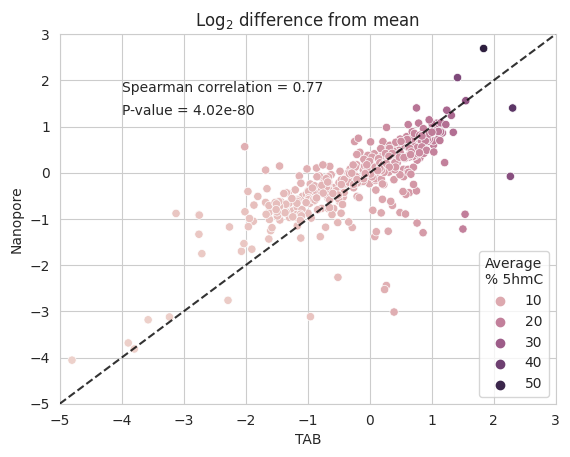

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig = plt.figure()

ax1 = fig.add_subplot()

sns.scatterplot(gene_df, x= "log2_diffFromMean_TAB", y="log2_diffFromMean_Nanopore", hue="average_percentMeth", ax=ax1)
sns.move_legend(ax1, "lower right", title="Average\n% 5hmC")
ax1.set_xlim(-5, 3)
ax1.set_ylim(-5, 3)
ax1.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), linestyle="dashed", color="black", zorder=5, alpha=0.8)
ax1.set_title("Log$_{2}$ difference from mean")
ax1.text(-4, 1.75, "Spearman correlation = {rho:.2f}".format(rho=rho[0]))
ax1.text(-4, 1.25, "P-value = {rho:.2e}".format(rho=rho[1]), )
ax1.set_xlabel("TAB")
ax1.set_ylabel("Nanopore")

fig.show()
